In [17]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.cluster import KMeans


## Data discovery ##

In [18]:
df = pd.read_csv("steam-200k.csv", header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Other'])
df.head()

,UserID,Game,Action,Hours,Other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [19]:
# infos for action "play", seems more relevant to me.
# we want here to exclude the action = 'purchase' with Hours = 1.0 that are not relevant in the mean computation 
df.loc[df['Action'] == 'play'].describe()



,UserID,Hours,Other
count,7.048900e+04,70489.000000,70489.0
mean,1.058812e+08,48.878063,0.0
std,7.150365e+07,229.335236,0.0
min,5.250000e+03,0.100000,0.0
25%,4.934256e+07,1.000000,0.0
50%,9.169067e+07,4.500000,0.0
75%,1.556738e+08,19.100000,0.0
max,3.099031e+08,11754.000000,0.0


In this, we will check if each time a player buys a games, he plays it

In [20]:
values = df.groupby(['UserID', 'Action']).size()
values.head()

UserID  Action  
5250    play         6
        purchase    21
76767   play        20
        purchase    36
86540   play        15
dtype: int64

We can see that for some users, we have some infos about bought games but no infos about the time played, so we will try to consider this skew in the following

In [21]:
print("Number of games : {0}".format(len(df.Game.unique())))
print("Number of users : {0}".format(len(df.UserID.unique())))
print("Number of total purchases : {0}".format(len(df.loc[df['Action'] == 'purchase'])))
print("Number of total plays infos : {0}".format(len(df.loc[df['Action'] == 'play'])))





Number of games : 5155
Number of users : 12393
Number of total purchases : 129511
Number of total plays infos : 70489


We have dyssimetric informations between the purchases and the played times.

## Game and Users Analysis ##
First, we will plot how many times each game is purchased. Also we will plot how many hours it is played to see if the most purchased games are the most played.

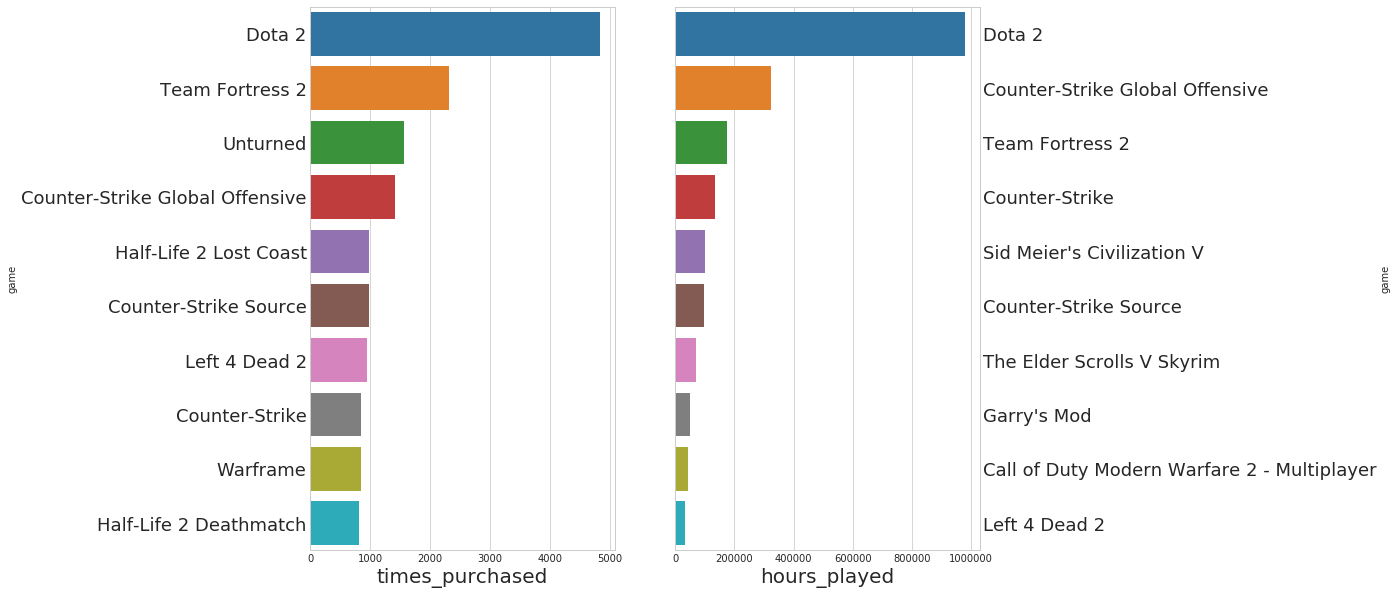

In [22]:
nb_games = 10
df_purchase = df.loc[df['Action'] == 'purchase']
purchased_times = df_purchase.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
purchased_times = pd.DataFrame({'game': purchased_times.index, 'times_purchased': purchased_times.values})[0:nb_games]

df_play = df.loc[df['Action'] == 'play']
hours_played = df_play.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

fig, ax =plt.subplots(1,2,figsize=(12,nb_games))

sns.barplot(y = 'game', x = 'times_purchased', data = purchased_times, ax=ax[0])
sns.barplot(y = 'game', x = 'hours_played', data = hours_played, ax=ax[1])


ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
for i in range(0,2):
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].xaxis.label.set_size(20)


In [23]:
print(purchased_times)

                              game  times_purchased
0                           Dota 2             4841
1                  Team Fortress 2             2323
2                         Unturned             1563
3  Counter-Strike Global Offensive             1412
4           Half-Life 2 Lost Coast              981
5            Counter-Strike Source              978
6                    Left 4 Dead 2              951
7                   Counter-Strike              856
8                         Warframe              847
9           Half-Life 2 Deathmatch              823


Now let's sort the most active users by hours played and have a glance at the game they play.

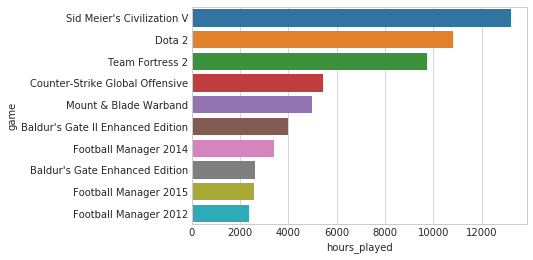

In [24]:
top = 10
user_counts = df.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)[0:top]
mask = df['UserID'].isin(user_counts.index)
df_infos_user = df.loc[mask].loc[df['Action'] == 'play']
hours_played = df_infos_user.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

sns.barplot(y = 'game', x = 'hours_played', data = hours_played)



By testing several value for the number of top gamers, we observe some surprising to-played games like CIvilization V being the most played within the top whereas only on the 5th position of the most-played games.
Same thing for Mount & Blade Warband, not appearing in the top10 most played games for all users but present in the top with we only keep the most active players. We will now try to observe this distribution of played time for those particular games, and maybe differenciate the famous games played less than some less known games but causing hardcore gaming. 

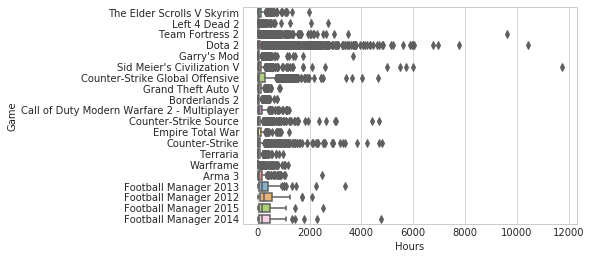

In [25]:
nb_top_games = 20
hours_played = df_play.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
top_played_games = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_top_games]

mask = df['Game'].isin(top_played_games['game'])

df_infos_user = df.loc[mask].loc[df['Action'] == 'play'][['Hours', 'Game']]


sns.set_style("whitegrid")
sns.boxplot(x="Hours", y="Game", data=df_infos_user, palette="Set3")


As we can see, there are some games staying quite close to the mean played games, whereas some others like FM or Civilization have some vert extremal played times.

## User Classification ##
In this we will try to find some clusters for users, to determine profile of gamers.
To do so, we will try to use :

- Nb Purchased Games vs Hours Played
- Nb Played Games vs Hours Played
- Nb Actions vs Hours Played

/home/matheus/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


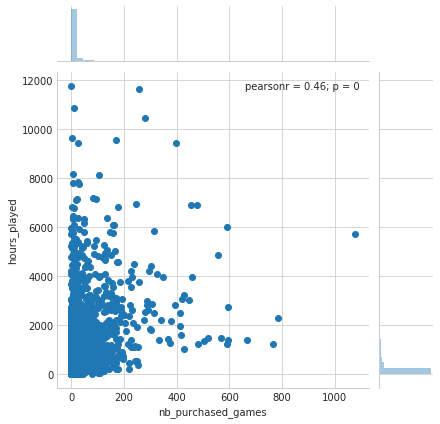

In [26]:
df_purchased_games = df.loc[df['Action'] == 'purchase']
df_played_games = df.loc[df['Action'] == 'play']

#here we compute the number of games a user has bought
user_counts = df_purchased_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
#here we compute the number of hours he has played 
hours_played = df_played_games.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)

#df creation
user_df_purchased_games = pd.DataFrame({'UserID': user_counts.index, 'nb_purchased_games': user_counts.values})
user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})

#merge to have one entry per user with number of hours played and number of purchased games
data = pd.merge(user_df_purchased_games, user_df_hours_played, on='UserID')
sns.jointplot(x="nb_purchased_games", y="hours_played", data=data)# , kind="reg")

Hard to find a pattern in this ... Let's try the log scale on y

/home/matheus/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


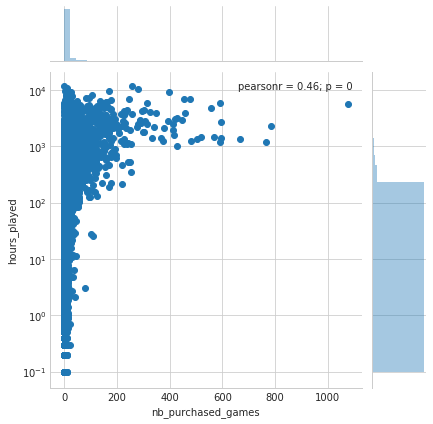

In [27]:
g = sns.jointplot(x="nb_purchased_games", y="hours_played", data=data )#, kind="reg")
ax = g.ax_joint
ax.set_yscale('log')
g.ax_marg_y.set_yscale('log')
g

/home/matheus/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


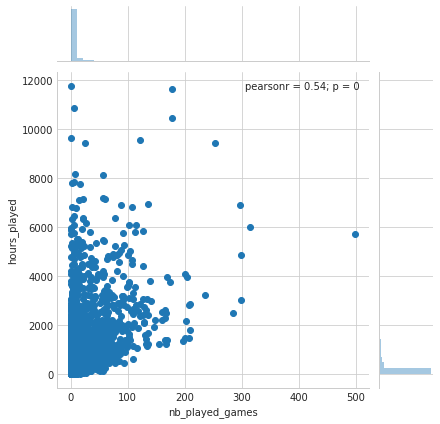

In [28]:
#here we compute the number of games a user has played
user_counts = df_played_games.groupby('UserID')['UserID'].agg('count').sort_values(ascending=False)
#here we compute the number of hours he has played 
hours_played = df_played_games.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)

#df creation
user_df_played_games = pd.DataFrame({'UserID': user_counts.index, 'nb_played_games': user_counts.values})
user_df_hours_played = pd.DataFrame({'UserID': hours_played.index, 'hours_played': hours_played.values})


#merge to have one entry per user with number of hours played and number of played games
data = pd.merge(user_df_played_games, user_df_hours_played, on='UserID')

sns.jointplot(x="nb_played_games", y="hours_played", data=data )# , kind="reg")


With log scale on y axe

/home/matheus/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


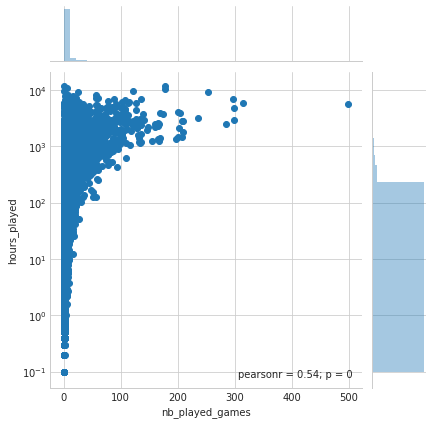

In [29]:
g = sns.jointplot(x="nb_played_games", y="hours_played", data=data )#, kind="reg")
ax = g.ax_joint
ax.set_yscale('log')
g.ax_marg_y.set_yscale('log')
g

To much noise in the dataset, we should try to eliminate those absurd values to focus more precisely on the core of the points.

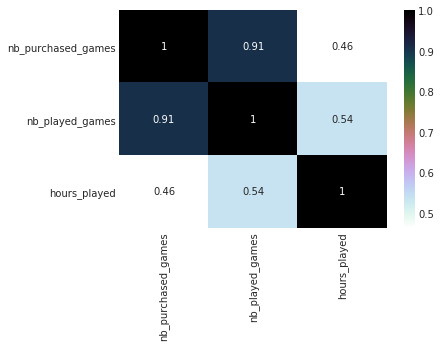

In [30]:
temp = pd.merge(user_df_purchased_games, data, on='UserID')
temp = temp.copy()
del temp['UserID'] #don't need this for k mean
sns.heatmap(temp.corr(),annot=True,cmap='cubehelix_r') #draws  heatmap with input as the correlatio

Logically, we have a strong correlation between the number of **played games** and the number of **purchased games**

**K MEANS**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


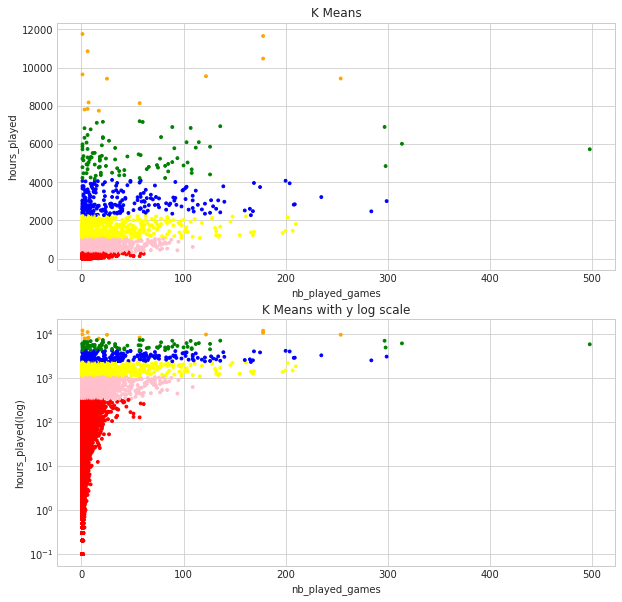

In [31]:
# K Means
temp = data.copy()
del temp['UserID'] #don't need this for k mean

N_CLUSTERS = 6
train_data = temp.as_matrix()
# Using sklearn
km = KMeans(n_clusters=N_CLUSTERS)
km.fit(train_data)
# Get cluster assignment labels
labels = km.labels_ # 0 to n_clusters-1
# Format results as a DataFrame

LABEL_COLOR_MAP = {0 : 'red',
                   1 : 'blue',
                   2 : 'green',
                   3 : 'yellow',
                   4 : 'orange',
                   5 : 'pink'
                  }

label_color = [LABEL_COLOR_MAP[l] for l in labels]


fig, ax =plt.subplots(2,1,figsize=(10,10))
ax[0].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[0].set_xlabel('nb_played_games')
ax[0].set_ylabel('hours_played')
ax[0].set_title('K Means')

ax[1].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[1].set_xlabel('nb_played_games')
ax[1].set_ylabel('hours_played(log)')
ax[1].set_title('K Means with y log scale')
ax[1].set_yscale('log')


**Gaussian Mixture**

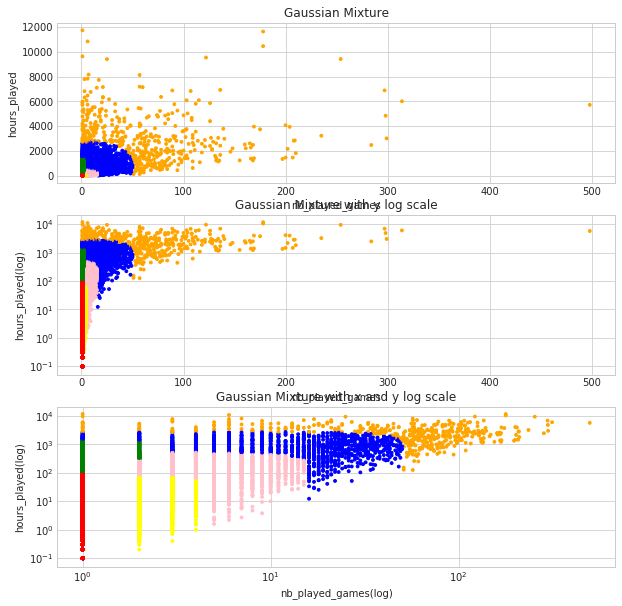

In [32]:
from sklearn.mixture import GaussianMixture
cov_types = ['spherical', 'diag', 'tied', 'full']

gm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag')
gm.fit(train_data)
y_train_pred = gm.predict(train_data)
label_color = [LABEL_COLOR_MAP[l] for l in y_train_pred]

fig, ax =plt.subplots(3,1,figsize=(10,10))
ax[0].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[0].set_xlabel('nb_played_games')
ax[0].set_ylabel('hours_played')
ax[0].set_title('Gaussian Mixture')

ax[1].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[1].set_xlabel('nb_played_games')
ax[1].set_ylabel('hours_played(log)')
ax[1].set_title('Gaussian Mixture with y log scale')
ax[1].set_yscale('log')

ax[2].scatter(data[['nb_played_games']], data[['hours_played']], c=label_color, s=8, marker='o')
ax[2].set_xlabel('nb_played_games(log)')
ax[2].set_ylabel('hours_played(log)')
ax[2].set_title('Gaussian Mixture with x and y log scale')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
